DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

HRTFs project work assign
Hi everyone, welcome to HRTF group!

In this project, our goal is to predict Head-Related Transfer Functions (HRTFs) using a combination of 3D ear landmarks and high-resolution ear images as inputs. This colab fileLinks to an external site. is one of my approach (which is called multi-input method) to achive that.
Before we begin, I want each of you to read the following code carefully, (it may take a little while to understand it). Then use it as a starting point to accomplish your task.But there is one thing I want all of you to notice that in your code you should change all data to use the left ear (currently only the right ear is used).
Based on this code, Below are the directions and assignments for each of you to focus on. Please make sure to dive deep into your area and provide insights that will help improve our project. Let's work together and make it successful!


3. CNN to Predict Landmark

Assigned to: Linjie Yu

Description: In our past experiments, we found that CNN's performance is better than transformer for predicting landmarks. Transformer with position encoding performed better than the purely transformer architecture, but CNN still outperformed both. One possible reason for this is that our dataset is relatively small (only 61 objects), so simpler architectures like CNNs might be more suitable. CNNs have been proven to be effective for smaller datasets due to their ability to capture spatial features with fewer parameters compared to transformers. Given this observation, we will focus on utilizing CNNs for landmark prediction.



Task: Your task is to design and train a Convolutional Neural Network (CNN) specifically for predicting landmarks and combine it with the image prediction . You can start by experimenting with different CNN architectures—adjusting the number of layers, filter sizes, and activation functions—to find the most effective one. Since we know that CNNs tend to perform better with smaller datasets, your goal is to fine-tune the model and optimize it for our specific task. Pay attention to how well it generalizes and test the model. You are free to introduce regularization techniques like dropout, batch normalization, or any other techniques that you believe might improve performance. Additionally, you can experiment with different loss functions that may be better suited for our problem.



If you have any questions or run into any issues, feel free to reach out to me at any time. I believe each of you will bring unique insights to your respective tasks, and together, we can make great progress. Let's work closely as a team, and I hope that by the end of this project, you'll not only achieve excellent results but also gain valuable experience and knowledge in deep learning and HRTF prediction.

Good luck, and I'm looking forward to seeing all the amazing work you'll accomplish!

In [17]:
!pip install cartopy
!pip install pysofaconventions
!pip install efficientnet_pytorch

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import scipy.io
import numpy as np
import os
import glob
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split, ConcatDataset
from scipy.fftpack import fft
from PIL import Image
from torchvision import transforms

# SFRS parameters
num_points = 393

# FFT parameters
NFFT = 8192
desired_freq = 20000
sampleFreq = 48000
frequencies = np.linspace(0, sampleFreq, NFFT)[:NFFT//2]
freq_bin = np.argmin(np.abs(frequencies - desired_freq))

def convert_to_hrtf_magnitude_norm(hrir_data, NFFT):
    frequency_response = fft(hrir_data, NFFT)[:NFFT //2]
    magnitude = np.abs(frequency_response)
    max_magnitude = np.max(magnitude)
    normalized_magnitude = magnitude / max_magnitude
    magnitude_db = 20 * np.log10(normalized_magnitude[freq_bin] + np.finfo(float).eps)
    return magnitude_db

def mirror_landmarks(landmarks):
    mirrored_landmarks = landmarks.copy()
    mirrored_landmarks[:, 1] = -mirrored_landmarks[:, 1]
    return mirrored_landmarks

def mirror_hrtf(hrtf, azimuths, elevations):
    mirrored_hrtf = np.zeros_like(hrtf)
    for i, (az, el) in enumerate(zip(azimuths, elevations)):
        opposite_az = -az
        opposite_idx = np.where((azimuths == opposite_az) & (elevations == el))[0]
        if len(opposite_idx) > 0:
            mirrored_hrtf[i] = hrtf[opposite_idx[0]]
    return mirrored_hrtf

def add_gaussian_noise(landmarks, mean=0, std=0.01):
    noise = np.random.normal(mean, std, landmarks.shape)
    noised_landmarks = landmarks.copy()
    noised_landmarks += noise
    return noised_landmarks

def normalize(data):
    data_3d = np.stack(data)
    mean = data_3d.mean(axis=0)
    std = data_3d.std(axis=0)
    normalized_data = (data_3d - mean) / std
    return normalized_data

# Load landmark data
data = scipy.io.loadmat('drive/MyDrive/5305/3DShapeData.mat')
A = data['A'].flatten()

# Load azimuth and elevation data
azim_data = scipy.io.loadmat('drive/MyDrive/5305/Parameters/azim.mat')['azim'].squeeze()
elev_data = scipy.io.loadmat('drive/MyDrive/5305/Parameters/elev.mat')['elev'].squeeze()

# Load HRIR data
folder_path = 'drive/MyDrive/5305/Acoustic'
file_paths = glob.glob(os.path.join(folder_path, 'HA*.mat'))

sample_hrir_data_L = scipy.io.loadmat(file_paths[0])['hL']
num_measurements = sample_hrir_data_L.shape[1]
num_samples = sample_hrir_data_L.shape[0]
num_files = len(file_paths)

hrir_all_L = np.zeros((num_files, num_samples, num_measurements))
hrir_all_R = np.zeros((num_files, num_samples, num_measurements))

for idx, file_path in enumerate(file_paths):
    hrir_all_L[idx, :, :] = scipy.io.loadmat(file_path)['hL']
    hrir_all_R[idx, :, :] = scipy.io.loadmat(file_path)['hR']

# Convert HRIR data to magnitude
hrtf_magnitude_db_all_L = np.zeros((num_files, num_measurements))
hrtf_magnitude_db_all_R = np.zeros((num_files, num_measurements))

for file_idx, hrir in enumerate(hrir_all_L):
    for measurement_idx in range(num_measurements):
        hrtf_magnitude_db_all_L[file_idx, measurement_idx] = convert_to_hrtf_magnitude_norm(hrir[:, measurement_idx], NFFT)

for file_idx, hrir in enumerate(hrir_all_R):
    for measurement_idx in range(num_measurements):
        hrtf_magnitude_db_all_R[file_idx, measurement_idx] = convert_to_hrtf_magnitude_norm(hrir[:, measurement_idx], NFFT)

# Process landmark data
A_processed = normalize(A)
mirrored = np.zeros_like(A_processed)
for idx, landmarks in enumerate(A_processed):
    mirrored[idx] = mirror_landmarks(landmarks)

A_processed = torch.tensor(A_processed).float()
A_processed = A_processed.permute(0, 2, 1)
mirrored = torch.tensor(mirrored).float()
mirrored = mirrored.permute(0, 2, 1)

hL_tensor = torch.tensor(hrtf_magnitude_db_all_L).float().view(-1, 393)
hR_tensor = torch.tensor(hrtf_magnitude_db_all_R).float().view(-1, 393)

mirrored_hL = np.zeros_like(hrtf_magnitude_db_all_R)
mirrored_hR = np.zeros_like(hrtf_magnitude_db_all_L)
for idx, hrtf in enumerate(hrtf_magnitude_db_all_R):
    mirrored_hL[idx] = mirror_hrtf(hrtf, azim_data, elev_data)
for idx, hrtf in enumerate(hrtf_magnitude_db_all_L):
    mirrored_hR[idx] = mirror_hrtf(hrtf, azim_data, elev_data)

mirrored_hL_tensor = torch.tensor(mirrored_hL).float().view(-1, 393)
mirrored_hR_tensor = torch.tensor(mirrored_hR).float().view(-1, 393)

# Load and process image data
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(image)

image_folder = 'drive/MyDrive/5305/images'
left_ear_images = []
right_ear_images = []

for i in range(1, num_files + 1):
    left_image_path = os.path.join(image_folder, 'LeftEar', f'HE{i:02d}.png')
    right_image_path = os.path.join(image_folder, 'RightEar', f'HE{i:02d}.png')

    left_ear_images.append(load_and_preprocess_image(left_image_path))
    right_ear_images.append(load_and_preprocess_image(right_image_path))

left_ear_images = torch.stack(left_ear_images)
right_ear_images = torch.stack(right_ear_images)

# Create mirrored images
mirrored_left_ear_images = torch.flip(right_ear_images, [3])  # Flip horizontally
mirrored_right_ear_images = torch.flip(left_ear_images, [3])  # Flip horizontally

# Create datasets
combined_landmarks = torch.cat((A_processed, mirrored), dim=0)
combined_hL = torch.cat((hL_tensor, mirrored_hL_tensor), dim=0)
combined_hR = torch.cat((hR_tensor, mirrored_hR_tensor), dim=0)
combined_left_images = torch.cat((left_ear_images, mirrored_left_ear_images), dim=0)
combined_right_images = torch.cat((right_ear_images, mirrored_right_ear_images), dim=0)

dataset_L = TensorDataset(combined_landmarks, combined_left_images, combined_hL)
dataset_R = TensorDataset(combined_landmarks, combined_right_images, combined_hR)

# Split datasets
def get_test_data(dataset, test_ratio=0.1):
    total_size = len(dataset)
    test_size = int(total_size * test_ratio)
    train_val_size = total_size - test_size
    return random_split(dataset, [train_val_size, test_size])

train_val_dataset_L, test_dataset_L = get_test_data(dataset_L)
train_val_dataset_R, test_dataset_R = get_test_data(dataset_R)

# Save datasets
torch.save(train_val_dataset_L, f"drive/MyDrive/5305/Data/Processed/train_val_norm_L{desired_freq/1000}k_with_images.pth")
torch.save(test_dataset_L, f"drive/MyDrive/5305/Data/Processed/test_norm_L{desired_freq/1000}k_with_images.pth")
torch.save(train_val_dataset_R, f"drive/MyDrive/5305/Data/Processed/train_val_norm_R{desired_freq/1000}k_with_images.pth")
torch.save(test_dataset_R, f"drive/MyDrive/5305/Data/Processed/test_norm_R{desired_freq/1000}k_with_images.pth")

# Add noise to landmarks for data augmentation
train_val_landmarks_L, train_val_images_L, train_val_hL = zip(*train_val_dataset_L)
train_val_landmarks_L = torch.stack(train_val_landmarks_L).numpy()

noised_train_val_landmarks_L = np.zeros_like(train_val_landmarks_L)
for idx, landmarks in enumerate(train_val_landmarks_L):
    noised_train_val_landmarks_L[idx] = add_gaussian_noise(landmarks)

noised_train_val_landmarks_L = torch.tensor(noised_train_val_landmarks_L).float()
dataset_noised_L = TensorDataset(noised_train_val_landmarks_L, torch.stack(train_val_images_L), torch.stack(train_val_hL))

# Combine original and noised datasets
train_combined_L = ConcatDataset([train_val_dataset_L, dataset_noised_L])

print("Data preparation completed. Datasets saved and ready for model training.")

Data preparation completed. Datasets saved and ready for model training.


Model 1:
Using CNN model to predict landmark, can get the minimal loss it 4.1

By usign the smooth_L1 loss function, 3 conv layer

optimize:AdamW

Schedule:ReduceLROnPlateau


Using device: cuda


<ipython-input-29-fc496dd16fd2>:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_val_dataset = torch.load("drive/MyDrive/5305/Data/Processed/train_val_norm_L20.0k_wi

Epoch [1/100], Training Loss: 19.309163
Epoch [2/100], Training Loss: 19.372113
Epoch [3/100], Training Loss: 18.722621
Epoch [4/100], Training Loss: 17.797797
Epoch [5/100], Training Loss: 16.154160
Epoch [6/100], Training Loss: 13.192715
Epoch [7/100], Training Loss: 9.155939
Epoch [8/100], Training Loss: 7.445712
Epoch [9/100], Training Loss: 6.877708
Epoch [10/100], Training Loss: 5.353069
Epoch [11/100], Training Loss: 4.887649
Epoch [12/100], Training Loss: 4.834159
Epoch [13/100], Training Loss: 4.761517
Epoch [14/100], Training Loss: 4.654588
Epoch [15/100], Training Loss: 4.600186
Epoch [16/100], Training Loss: 4.575979
Epoch [17/100], Training Loss: 4.537064
Epoch [18/100], Training Loss: 4.512418
Epoch [19/100], Training Loss: 4.461075
Epoch [20/100], Training Loss: 4.485117
Epoch [21/100], Training Loss: 4.554968
Epoch [22/100], Training Loss: 4.418293
Epoch [23/100], Training Loss: 4.385764
Epoch [24/100], Training Loss: 4.379826
Epoch [25/100], Training Loss: 4.404104
Epo

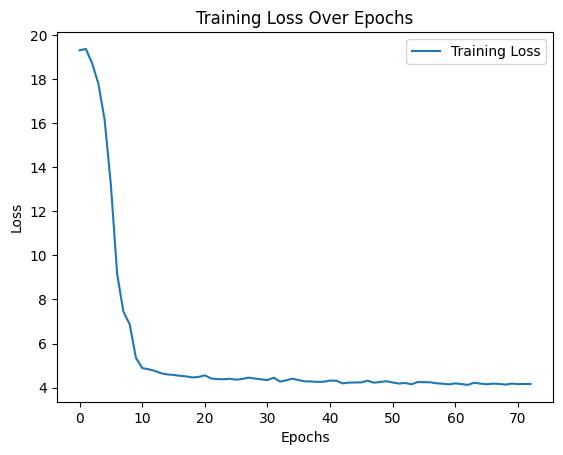

Final model saved as 'final_model.pth'.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt

# Model parameters
d_model = 512
dropout = 0.5  # Increase Dropout rate
lr = 1e-4
epochs = 100
weight_decay = 1e-3  # Increase weight decay
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LandmarkCNN(nn.Module):
    def __init__(self, input_dim=3, num_points=33, embedding_dim=d_model):
        super(LandmarkCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear(256 * (num_points // 4), embedding_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change to [batch_size, input_dim, num_points]
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self, input_dim=3, num_points=33, num_output=393):
        super(CombinedModel, self).__init__()
        self.landmark_cnn = LandmarkCNN(input_dim=input_dim, num_points=num_points)

        # ResNet processing for images
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, d_model)

        # Combine features and predict output
        self.combine_features = nn.Linear(d_model * 2, d_model * 2)  # Increase output dimension of combine layer
        self.dropout = nn.Dropout(dropout)
        self.linear_out = nn.Linear(d_model * 2, num_output)

    def forward(self, landmarks, images):
        x_landmarks = self.landmark_cnn(landmarks)
        x_images = self.resnet(images)

        combined = torch.cat((x_landmarks, x_images), dim=1)
        x = self.combine_features(combined)
        x = self.dropout(x)
        x = self.linear_out(x)

        return x

# Define custom loss function
def smooth_l1_loss(output, target):
    return nn.SmoothL1Loss()(output, target)

# Define the training process with early stopping
def train_model(model, train_loader, optimizer, scheduler, epochs, patience=10):
    model.train()
    train_losses = []
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        running_loss = 0.0
        for landmarks, images, labels in train_loader:
            landmarks, images, labels = landmarks.permute(0, 2, 1).to(device), images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(landmarks, images)
            loss = smooth_l1_loss(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_loss:.6f}')

        # Adjust learning rate and apply early stopping
        scheduler.step(avg_loss)
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "best_model.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    return train_losses

# Load and prepare data
train_val_dataset = torch.load("drive/MyDrive/5305/Data/Processed/train_val_norm_L20.0k_with_images.pth")
train_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer, and scheduler
model = CombinedModel().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Train the model
train_losses = train_model(model, train_loader, optimizer, scheduler, epochs)

# Visualize the training results
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Save the final model after training
torch.save(model.state_dict(), "final_model.pth")
print("Final model saved as 'final_model.pth'.")


Method 2: minimal loss 31.2


This model is a multimodal neural network combining CNN and ResNet architectures to process both landmark and image data simultaneously. It has two main components: the LandmarkCNN for extracting features from keypoints and a ResNet18 for extracting image features. The extracted features are fused in a fully connected layer to produce the final output. Data augmentation and L2 regularization are used to improve generalization, with a custom loss function and learning rate scheduler to optimize training.

Using device: cuda


<ipython-input-58-3c83cee0d1fe>:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_val_dataset = torch.load("drive/MyDrive/5305/Data/Processed/train_val_norm_L20.0k_wi

Epoch [1/100], Training Loss: 330.732775
Epoch [2/100], Training Loss: 85.458258
Epoch [3/100], Training Loss: 67.615068
Epoch [4/100], Training Loss: 55.993249
Epoch [5/100], Training Loss: 52.334321
Epoch [6/100], Training Loss: 49.357338
Epoch [7/100], Training Loss: 47.209416
Epoch [8/100], Training Loss: 46.642194
Epoch [9/100], Training Loss: 45.578436
Epoch [10/100], Training Loss: 46.080968
Epoch [11/100], Training Loss: 43.997486
Epoch [12/100], Training Loss: 44.794936
Epoch [13/100], Training Loss: 45.304607
Epoch [14/100], Training Loss: 44.821262
Epoch [15/100], Training Loss: 42.895287
Epoch [16/100], Training Loss: 42.120167
Epoch [17/100], Training Loss: 43.572349
Epoch [18/100], Training Loss: 42.211805
Epoch [19/100], Training Loss: 42.334374
Epoch [20/100], Training Loss: 41.485299
Epoch [21/100], Training Loss: 48.712603
Epoch [22/100], Training Loss: 42.846274
Epoch [23/100], Training Loss: 41.449741
Epoch [24/100], Training Loss: 40.456347
Epoch [25/100], Training

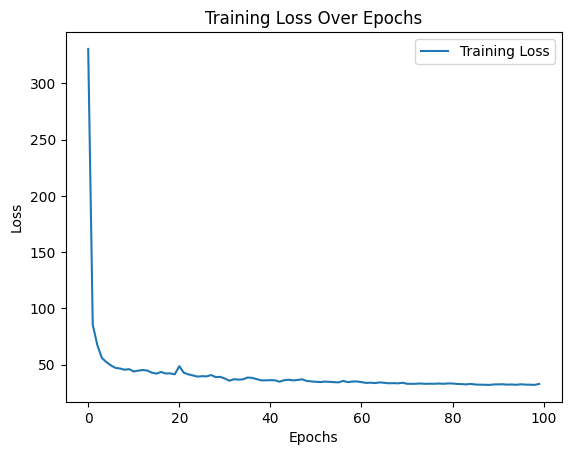

Training completed. Best model saved as 'best_model.pth'.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt

# Model parameters
d_model = 512
dropout = 0.5
lr = 1e-3
epochs = 100
weight_decay = 1e-4
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class LandmarkCNN(nn.Module):
    def __init__(self, input_dim=3, num_points=33, embedding_dim=d_model):
        super(LandmarkCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool1d(2)
        self.fc = nn.Linear(256 * (num_points // 8), embedding_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Transform to [batch_size, input_dim, num_points]
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class CombinedModel(nn.Module):
    def __init__(self, input_dim=3, num_points=33, num_output=393):
        super(CombinedModel, self).__init__()
        self.landmark_cnn = LandmarkCNN(input_dim=input_dim, num_points=num_points)

        # ResNet processing for images
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, d_model)

        # Combine features and predict output
        self.combine_features = nn.Linear(d_model * 2, d_model)
        self.dropout = nn.Dropout(dropout)
        self.linear_out = nn.Linear(d_model, num_output)

    def forward(self, landmarks, images):
        x_landmarks = self.landmark_cnn(landmarks)
        x_images = self.resnet(images)

        combined = torch.cat((x_landmarks, x_images), dim=1)
        x = self.combine_features(combined)
        x = self.dropout(x)
        x = self.linear_out(x)
        return x

# Data augmentation function: add noise to landmarks and images
def augment_data(landmarks, images, noise_std=0.01):
    landmarks += torch.randn_like(landmarks) * noise_std

    # Image data augmentation
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1))
    ])
    augmented_images = torch.stack([transform(img) for img in images])

    return landmarks, augmented_images

# Define loss function with L2 regularization
def mse_loss_with_l2(output, target, model, l2_lambda=1e-5):
    mse_loss = nn.MSELoss()(output, target)
    l2_reg = torch.tensor(0.).to(device)

    for param in model.parameters():
        l2_reg += torch.norm(param) ** 2  # Calculate L2 norm squared for all parameters

    return mse_loss + l2_lambda * l2_reg  # Total loss = MSE + L2 regularization term

# Define training process
def train_model(model, train_loader, optimizer, scheduler, epochs, l2_lambda=1e-5):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        running_loss = 0.0

        for landmarks, images, labels in train_loader:
            # Data augmentation
            landmarks, images = augment_data(landmarks, images)
            landmarks, images, labels = landmarks.permute(0, 2, 1).to(device), images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(landmarks, images)
            loss = mse_loss_with_l2(outputs, labels, model, l2_lambda=l2_lambda)  # Use loss with L2 regularization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch + 1}/{epochs}], Training Loss: {avg_loss:.6f}')

        # Update learning rate
        scheduler.step()

    return train_losses

# Load and prepare data
train_val_dataset = torch.load("drive/MyDrive/5305/Data/Processed/train_val_norm_L20.0k_with_images.pth")
train_loader = DataLoader(train_val_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer, and StepLR scheduler
model = CombinedModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)  # StepLR scheduler

# Train the model
train_losses = train_model(model, train_loader, optimizer, scheduler, epochs)

# Visualize the training results
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Save the best model after training
torch.save(model.state_dict(), "best_model.pth")
print("Training completed. Best model saved as 'best_model.pth'.")


Test the model

<ipython-input-60-52dfc9051c30>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best.load_state_dict(torch.load("best_model.pth", map_location=device))


Testing best model:
Best Model Test Loss: 42.875324


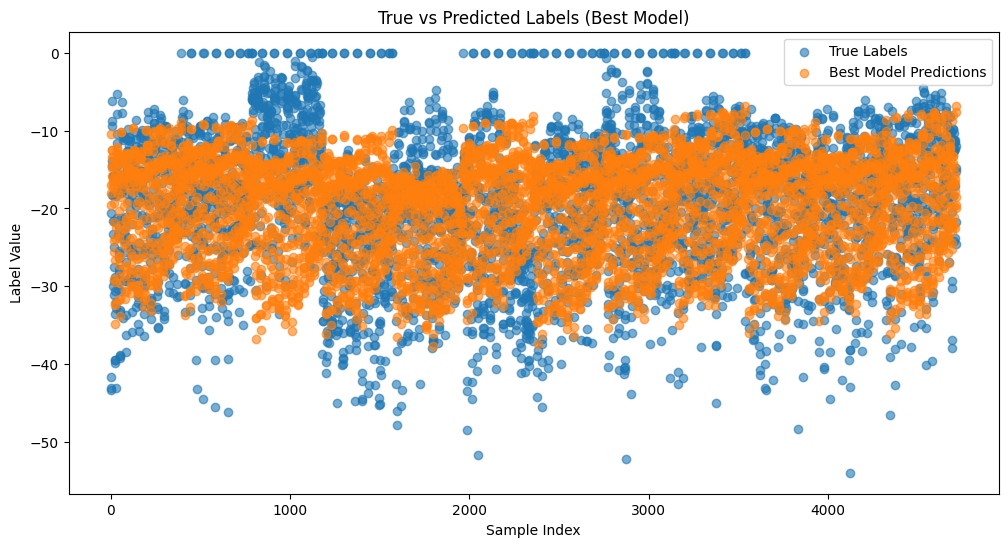

In [ ]:

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn as nn
import torch.serialization
import numpy as np
import scipy.io

# Set the path to the test data
test_data_path = "/content/drive/MyDrive/5305/Data/Processed/test_norm_L20.0k_with_images.pth"

# Allow specific global classes to resolve deserialization issues
torch.serialization.add_safe_globals([torch.utils.data.dataset.Subset])

# Load the test data
test_dataset = torch.load(test_data_path, weights_only=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model and load the trained weights
model_best = CombinedModel().to(device)
model_best.load_state_dict(torch.load("best_model.pth", map_location=device))
model_best.eval()

# Load azimuth and elevation data
azim_data = scipy.io.loadmat('drive/MyDrive/5305/Parameters/azim.mat')['azim'].squeeze()
elev_data = scipy.io.loadmat('drive/MyDrive/5305/Parameters/elev.mat')['elev'].squeeze()

# Define the testing process
def test_model(model, test_loader):
    model.eval()
    total_loss = 0.0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for landmarks, images, labels in test_loader:
            landmarks, images, labels = landmarks.permute(0, 2, 1).to(device), images.to(device), labels.to(device)
            outputs = model(landmarks, images)
            loss = nn.MSELoss()(outputs, labels)
            total_loss += loss.item()

            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    avg_loss = total_loss / len(test_loader)
    return avg_loss, torch.cat(all_outputs), torch.cat(all_labels)

# Test the model
print("Testing best model:")
best_loss, best_predicted_labels, best_true_labels = test_model(model_best, test_loader)
print(f'Best Model Test Loss: {best_loss:.6f}')

# Visualize the results
best_predicted_labels = best_predicted_labels.flatten()
best_true_labels = best_true_labels.flatten()

# Ensure x and y are the same size
min_len_best = min(len(best_true_labels), len(best_predicted_labels))
best_true_labels = best_true_labels[:min_len_best]
best_predicted_labels = best_predicted_labels[:min_len_best]

# Visualize the results of the best model
plt.figure(figsize=(12, 6))
plt.scatter(range(len(best_true_labels)), best_true_labels, label='True Labels', alpha=0.6)
plt.scatter(range(len(best_predicted_labels)), best_predicted_labels, label='Best Model Predictions', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Label Value')
plt.title('True vs Predicted Labels (Best Model)')
plt.legend()
plt.show()


Using pretraining mode resNet18

Using device: cuda


<ipython-input-7-2a5035701b4c>:146: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_val_dataset = torch.load(f"drive/MyDrive/5305/Data/Processed/train_val_norm_L{desired

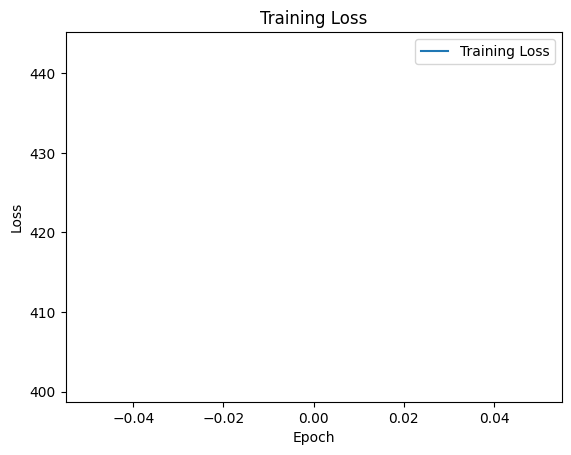

Epoch [1/300]: Training Loss: 421.954991


<Figure size 640x480 with 0 Axes>

Epoch [2/300]: Training Loss: 202.496968


<Figure size 640x480 with 0 Axes>

Epoch [3/300]: Training Loss: 74.870234


<Figure size 640x480 with 0 Axes>

Epoch [4/300]: Training Loss: 46.838734


<Figure size 640x480 with 0 Axes>

Epoch [5/300]: Training Loss: 47.846763


<Figure size 640x480 with 0 Axes>

Epoch [6/300]: Training Loss: 39.602572


<Figure size 640x480 with 0 Axes>

Epoch [7/300]: Training Loss: 36.322308


<Figure size 640x480 with 0 Axes>

Epoch [8/300]: Training Loss: 36.759168


<Figure size 640x480 with 0 Axes>

Epoch [9/300]: Training Loss: 35.895424


<Figure size 640x480 with 0 Axes>

Epoch [10/300]: Training Loss: 35.595642


<Figure size 640x480 with 0 Axes>

Epoch [11/300]: Training Loss: 35.283942


<Figure size 640x480 with 0 Axes>

Epoch [12/300]: Training Loss: 35.229916


<Figure size 640x480 with 0 Axes>

Epoch [13/300]: Training Loss: 35.189243


<Figure size 640x480 with 0 Axes>

Epoch [14/300]: Training Loss: 34.522744


<Figure size 640x480 with 0 Axes>

Epoch [15/300]: Training Loss: 34.509847


<Figure size 640x480 with 0 Axes>

Epoch [16/300]: Training Loss: 35.386196


<Figure size 640x480 with 0 Axes>

Epoch [17/300]: Training Loss: 34.982888


<Figure size 640x480 with 0 Axes>

Epoch [18/300]: Training Loss: 34.549183


<Figure size 640x480 with 0 Axes>

Epoch [19/300]: Training Loss: 34.849212


<Figure size 640x480 with 0 Axes>

Epoch [20/300]: Training Loss: 34.243437


<Figure size 640x480 with 0 Axes>

Epoch [21/300]: Training Loss: 33.523124


<Figure size 640x480 with 0 Axes>

Epoch [22/300]: Training Loss: 33.812916


<Figure size 640x480 with 0 Axes>

Epoch [23/300]: Training Loss: 33.853943


<Figure size 640x480 with 0 Axes>

Epoch [24/300]: Training Loss: 34.260116


<Figure size 640x480 with 0 Axes>

Epoch [25/300]: Training Loss: 34.187945


<Figure size 640x480 with 0 Axes>

Epoch [26/300]: Training Loss: 33.939722


<Figure size 640x480 with 0 Axes>

Epoch [27/300]: Training Loss: 33.131042


<Figure size 640x480 with 0 Axes>

Epoch [28/300]: Training Loss: 32.687899


<Figure size 640x480 with 0 Axes>

Epoch [29/300]: Training Loss: 32.614263


<Figure size 640x480 with 0 Axes>

Epoch [30/300]: Training Loss: 32.263236


<Figure size 640x480 with 0 Axes>

Epoch [31/300]: Training Loss: 31.753720


<Figure size 640x480 with 0 Axes>

Epoch [32/300]: Training Loss: 31.054537


<Figure size 640x480 with 0 Axes>

Epoch [33/300]: Training Loss: 31.756414


<Figure size 640x480 with 0 Axes>

Epoch [34/300]: Training Loss: 30.141507


<Figure size 640x480 with 0 Axes>

Epoch [35/300]: Training Loss: 29.091845


<Figure size 640x480 with 0 Axes>

Epoch [36/300]: Training Loss: 29.203432


<Figure size 640x480 with 0 Axes>

Epoch [37/300]: Training Loss: 28.843777


<Figure size 640x480 with 0 Axes>

Epoch [38/300]: Training Loss: 27.951089


<Figure size 640x480 with 0 Axes>

Epoch [39/300]: Training Loss: 28.031207


<Figure size 640x480 with 0 Axes>

Epoch [40/300]: Training Loss: 28.296402


<Figure size 640x480 with 0 Axes>

Epoch [41/300]: Training Loss: 28.359837


<Figure size 640x480 with 0 Axes>

Epoch [42/300]: Training Loss: 27.433938


<Figure size 640x480 with 0 Axes>

Epoch [43/300]: Training Loss: 26.722846


<Figure size 640x480 with 0 Axes>

Epoch [44/300]: Training Loss: 26.554481


<Figure size 640x480 with 0 Axes>

Epoch [45/300]: Training Loss: 25.682833


<Figure size 640x480 with 0 Axes>

Epoch [46/300]: Training Loss: 25.503614


<Figure size 640x480 with 0 Axes>

Epoch [47/300]: Training Loss: 25.318607


<Figure size 640x480 with 0 Axes>

Epoch [48/300]: Training Loss: 25.830504


<Figure size 640x480 with 0 Axes>

Epoch [49/300]: Training Loss: 25.342575


<Figure size 640x480 with 0 Axes>

Epoch [50/300]: Training Loss: 24.497668


<Figure size 640x480 with 0 Axes>

Epoch [51/300]: Training Loss: 24.207258


<Figure size 640x480 with 0 Axes>

Epoch [52/300]: Training Loss: 24.254675


<Figure size 640x480 with 0 Axes>

Epoch [53/300]: Training Loss: 24.691565


<Figure size 640x480 with 0 Axes>

Epoch [54/300]: Training Loss: 24.480442


<Figure size 640x480 with 0 Axes>

Epoch [55/300]: Training Loss: 24.708258


<Figure size 640x480 with 0 Axes>

Epoch [56/300]: Training Loss: 24.509417


<Figure size 640x480 with 0 Axes>

Epoch [57/300]: Training Loss: 23.471522


<Figure size 640x480 with 0 Axes>

Epoch [58/300]: Training Loss: 22.773719


<Figure size 640x480 with 0 Axes>

Epoch [59/300]: Training Loss: 22.442734


<Figure size 640x480 with 0 Axes>

Epoch [60/300]: Training Loss: 22.232294


<Figure size 640x480 with 0 Axes>

Epoch [61/300]: Training Loss: 22.910371


<Figure size 640x480 with 0 Axes>

Epoch [62/300]: Training Loss: 21.871119


<Figure size 640x480 with 0 Axes>

Epoch [63/300]: Training Loss: 21.783314


<Figure size 640x480 with 0 Axes>

Epoch [64/300]: Training Loss: 21.577921


<Figure size 640x480 with 0 Axes>

Epoch [65/300]: Training Loss: 21.464167


<Figure size 640x480 with 0 Axes>

Epoch [66/300]: Training Loss: 20.630907


<Figure size 640x480 with 0 Axes>

Epoch [67/300]: Training Loss: 21.150135


<Figure size 640x480 with 0 Axes>

Epoch [68/300]: Training Loss: 20.750847


<Figure size 640x480 with 0 Axes>

Epoch [69/300]: Training Loss: 20.402130


<Figure size 640x480 with 0 Axes>

Epoch [70/300]: Training Loss: 20.165509


<Figure size 640x480 with 0 Axes>

Epoch [71/300]: Training Loss: 20.810164


<Figure size 640x480 with 0 Axes>

Epoch [72/300]: Training Loss: 20.718625


<Figure size 640x480 with 0 Axes>

Epoch [73/300]: Training Loss: 21.459730


<Figure size 640x480 with 0 Axes>

Epoch [74/300]: Training Loss: 19.377182


<Figure size 640x480 with 0 Axes>

Epoch [75/300]: Training Loss: 19.705100


<Figure size 640x480 with 0 Axes>

Epoch [76/300]: Training Loss: 19.251755


<Figure size 640x480 with 0 Axes>

Epoch [77/300]: Training Loss: 19.754362


<Figure size 640x480 with 0 Axes>

Epoch [78/300]: Training Loss: 19.515590


<Figure size 640x480 with 0 Axes>

Epoch [79/300]: Training Loss: 18.557127


<Figure size 640x480 with 0 Axes>

Epoch [80/300]: Training Loss: 18.453051


<Figure size 640x480 with 0 Axes>

Epoch [81/300]: Training Loss: 19.186612


<Figure size 640x480 with 0 Axes>

Epoch [82/300]: Training Loss: 18.115188


<Figure size 640x480 with 0 Axes>

Epoch [83/300]: Training Loss: 18.024188


<Figure size 640x480 with 0 Axes>

Epoch [84/300]: Training Loss: 18.394118


<Figure size 640x480 with 0 Axes>

Epoch [85/300]: Training Loss: 18.201236


<Figure size 640x480 with 0 Axes>

Epoch [86/300]: Training Loss: 17.941736


<Figure size 640x480 with 0 Axes>

Epoch [87/300]: Training Loss: 18.145253


<Figure size 640x480 with 0 Axes>

Epoch [88/300]: Training Loss: 17.079942


<Figure size 640x480 with 0 Axes>

Epoch [89/300]: Training Loss: 17.764800


<Figure size 640x480 with 0 Axes>

Epoch [90/300]: Training Loss: 17.175556


<Figure size 640x480 with 0 Axes>

Epoch [91/300]: Training Loss: 17.477709


<Figure size 640x480 with 0 Axes>

Epoch [92/300]: Training Loss: 17.460600


<Figure size 640x480 with 0 Axes>

Epoch [93/300]: Training Loss: 17.583674


<Figure size 640x480 with 0 Axes>

Epoch [94/300]: Training Loss: 16.645563


<Figure size 640x480 with 0 Axes>

Epoch [95/300]: Training Loss: 16.850298


<Figure size 640x480 with 0 Axes>

Epoch [96/300]: Training Loss: 17.651690


<Figure size 640x480 with 0 Axes>

Epoch [97/300]: Training Loss: 17.212838


<Figure size 640x480 with 0 Axes>

Epoch [98/300]: Training Loss: 17.608583


<Figure size 640x480 with 0 Axes>

Epoch [99/300]: Training Loss: 17.414969


<Figure size 640x480 with 0 Axes>

Epoch [100/300]: Training Loss: 16.773328


<Figure size 640x480 with 0 Axes>

Epoch [101/300]: Training Loss: 16.706297


<Figure size 640x480 with 0 Axes>

Epoch [102/300]: Training Loss: 16.352122


<Figure size 640x480 with 0 Axes>

Epoch [103/300]: Training Loss: 15.990269


<Figure size 640x480 with 0 Axes>

Epoch [104/300]: Training Loss: 16.598099


<Figure size 640x480 with 0 Axes>

Epoch [105/300]: Training Loss: 16.037302


<Figure size 640x480 with 0 Axes>

Epoch [106/300]: Training Loss: 16.650086


<Figure size 640x480 with 0 Axes>

Epoch [107/300]: Training Loss: 15.910327


<Figure size 640x480 with 0 Axes>

Epoch [108/300]: Training Loss: 15.802136


<Figure size 640x480 with 0 Axes>

Epoch [109/300]: Training Loss: 15.777612


<Figure size 640x480 with 0 Axes>

Epoch [110/300]: Training Loss: 15.092165


<Figure size 640x480 with 0 Axes>

Epoch [111/300]: Training Loss: 15.375872


<Figure size 640x480 with 0 Axes>

Epoch [112/300]: Training Loss: 15.076945


<Figure size 640x480 with 0 Axes>

Epoch [113/300]: Training Loss: 15.465639


<Figure size 640x480 with 0 Axes>

Epoch [114/300]: Training Loss: 15.096389


<Figure size 640x480 with 0 Axes>

Epoch [115/300]: Training Loss: 14.992902


<Figure size 640x480 with 0 Axes>

Epoch [116/300]: Training Loss: 15.243718


<Figure size 640x480 with 0 Axes>

Epoch [117/300]: Training Loss: 15.690008


<Figure size 640x480 with 0 Axes>

Epoch [118/300]: Training Loss: 16.201958


<Figure size 640x480 with 0 Axes>

Epoch [119/300]: Training Loss: 14.987576


<Figure size 640x480 with 0 Axes>

Epoch [120/300]: Training Loss: 14.926848


<Figure size 640x480 with 0 Axes>

Epoch [121/300]: Training Loss: 15.155783


<Figure size 640x480 with 0 Axes>

Epoch [122/300]: Training Loss: 15.517315


<Figure size 640x480 with 0 Axes>

Epoch [123/300]: Training Loss: 14.982176


<Figure size 640x480 with 0 Axes>

Epoch [124/300]: Training Loss: 15.591315


<Figure size 640x480 with 0 Axes>

Epoch [125/300]: Training Loss: 14.888620


<Figure size 640x480 with 0 Axes>

Epoch [126/300]: Training Loss: 14.517599


<Figure size 640x480 with 0 Axes>

Epoch [127/300]: Training Loss: 14.462438


<Figure size 640x480 with 0 Axes>

Epoch [128/300]: Training Loss: 14.780161


<Figure size 640x480 with 0 Axes>

Epoch [129/300]: Training Loss: 13.758323


<Figure size 640x480 with 0 Axes>

Epoch [130/300]: Training Loss: 14.138027


<Figure size 640x480 with 0 Axes>

Epoch [131/300]: Training Loss: 14.060209


<Figure size 640x480 with 0 Axes>

Epoch [132/300]: Training Loss: 13.812111


<Figure size 640x480 with 0 Axes>

Epoch [133/300]: Training Loss: 13.888414


<Figure size 640x480 with 0 Axes>

Epoch [134/300]: Training Loss: 13.171732


<Figure size 640x480 with 0 Axes>

Epoch [135/300]: Training Loss: 13.756566


<Figure size 640x480 with 0 Axes>

Epoch [136/300]: Training Loss: 13.970623


<Figure size 640x480 with 0 Axes>

Epoch [137/300]: Training Loss: 13.974401


<Figure size 640x480 with 0 Axes>

Epoch [138/300]: Training Loss: 15.026246


<Figure size 640x480 with 0 Axes>

Epoch [139/300]: Training Loss: 13.815431


<Figure size 640x480 with 0 Axes>

Epoch [140/300]: Training Loss: 13.208933


<Figure size 640x480 with 0 Axes>

Epoch [141/300]: Training Loss: 13.313868


<Figure size 640x480 with 0 Axes>

Epoch [142/300]: Training Loss: 13.466578


<Figure size 640x480 with 0 Axes>

Epoch [143/300]: Training Loss: 13.267126


<Figure size 640x480 with 0 Axes>

Epoch [144/300]: Training Loss: 14.055466


<Figure size 640x480 with 0 Axes>

Epoch [145/300]: Training Loss: 13.025530


<Figure size 640x480 with 0 Axes>

Epoch [146/300]: Training Loss: 13.451943


<Figure size 640x480 with 0 Axes>

Epoch [147/300]: Training Loss: 12.845072


<Figure size 640x480 with 0 Axes>

Epoch [148/300]: Training Loss: 12.337898


<Figure size 640x480 with 0 Axes>

Epoch [149/300]: Training Loss: 12.949183


<Figure size 640x480 with 0 Axes>

Epoch [150/300]: Training Loss: 12.515957


<Figure size 640x480 with 0 Axes>

Epoch [151/300]: Training Loss: 13.314082


<Figure size 640x480 with 0 Axes>

Epoch [152/300]: Training Loss: 13.466022


<Figure size 640x480 with 0 Axes>

Epoch [153/300]: Training Loss: 13.552986


<Figure size 640x480 with 0 Axes>

Epoch [154/300]: Training Loss: 12.629608


<Figure size 640x480 with 0 Axes>

Epoch [155/300]: Training Loss: 12.179509


<Figure size 640x480 with 0 Axes>

Epoch [156/300]: Training Loss: 12.182835


<Figure size 640x480 with 0 Axes>

Epoch [157/300]: Training Loss: 12.038510


<Figure size 640x480 with 0 Axes>

Epoch [158/300]: Training Loss: 11.799468


<Figure size 640x480 with 0 Axes>

Epoch [159/300]: Training Loss: 12.066681


<Figure size 640x480 with 0 Axes>

Epoch [160/300]: Training Loss: 11.824501


<Figure size 640x480 with 0 Axes>

Epoch [161/300]: Training Loss: 11.989109


<Figure size 640x480 with 0 Axes>

Epoch [162/300]: Training Loss: 11.921580


<Figure size 640x480 with 0 Axes>

Epoch [163/300]: Training Loss: 11.475441


<Figure size 640x480 with 0 Axes>

Epoch [164/300]: Training Loss: 11.564428


<Figure size 640x480 with 0 Axes>

Epoch [165/300]: Training Loss: 11.500598


<Figure size 640x480 with 0 Axes>

Epoch [166/300]: Training Loss: 12.002040


<Figure size 640x480 with 0 Axes>

Epoch [167/300]: Training Loss: 12.485095


<Figure size 640x480 with 0 Axes>

Epoch [168/300]: Training Loss: 11.234052


<Figure size 640x480 with 0 Axes>

Epoch [169/300]: Training Loss: 11.579434


<Figure size 640x480 with 0 Axes>

Epoch [170/300]: Training Loss: 12.375927


<Figure size 640x480 with 0 Axes>

Epoch [171/300]: Training Loss: 11.751339


<Figure size 640x480 with 0 Axes>

Epoch [172/300]: Training Loss: 11.404396


<Figure size 640x480 with 0 Axes>

Epoch [173/300]: Training Loss: 11.315315


<Figure size 640x480 with 0 Axes>

Epoch [174/300]: Training Loss: 11.296919


<Figure size 640x480 with 0 Axes>

Epoch [175/300]: Training Loss: 11.071928


<Figure size 640x480 with 0 Axes>

Epoch [176/300]: Training Loss: 11.329683


<Figure size 640x480 with 0 Axes>

Epoch [177/300]: Training Loss: 11.003110


<Figure size 640x480 with 0 Axes>

Epoch [178/300]: Training Loss: 11.264515


<Figure size 640x480 with 0 Axes>

Epoch [179/300]: Training Loss: 11.177532


<Figure size 640x480 with 0 Axes>

Epoch [180/300]: Training Loss: 10.687625


<Figure size 640x480 with 0 Axes>

Epoch [181/300]: Training Loss: 10.971512


<Figure size 640x480 with 0 Axes>

Epoch [182/300]: Training Loss: 10.377000


<Figure size 640x480 with 0 Axes>

Epoch [183/300]: Training Loss: 10.576924


<Figure size 640x480 with 0 Axes>

Epoch [184/300]: Training Loss: 10.906635


<Figure size 640x480 with 0 Axes>

Epoch [185/300]: Training Loss: 10.849780


<Figure size 640x480 with 0 Axes>

Epoch [186/300]: Training Loss: 10.948843


<Figure size 640x480 with 0 Axes>

Epoch [187/300]: Training Loss: 10.611018


<Figure size 640x480 with 0 Axes>

Epoch [188/300]: Training Loss: 10.276887


<Figure size 640x480 with 0 Axes>

Epoch [189/300]: Training Loss: 10.858677


<Figure size 640x480 with 0 Axes>

Epoch [190/300]: Training Loss: 10.209490


<Figure size 640x480 with 0 Axes>

Epoch [191/300]: Training Loss: 10.415219


<Figure size 640x480 with 0 Axes>

Epoch [192/300]: Training Loss: 10.058585


<Figure size 640x480 with 0 Axes>

Epoch [193/300]: Training Loss: 10.585153


<Figure size 640x480 with 0 Axes>

Epoch [194/300]: Training Loss: 10.311872


<Figure size 640x480 with 0 Axes>

Epoch [195/300]: Training Loss: 10.142755


<Figure size 640x480 with 0 Axes>

Epoch [196/300]: Training Loss: 10.182476


<Figure size 640x480 with 0 Axes>

Epoch [197/300]: Training Loss: 10.280927


<Figure size 640x480 with 0 Axes>

Epoch [198/300]: Training Loss: 10.437526


<Figure size 640x480 with 0 Axes>

Epoch [199/300]: Training Loss: 10.473452


<Figure size 640x480 with 0 Axes>

Epoch [200/300]: Training Loss: 9.732201


<Figure size 640x480 with 0 Axes>

Epoch [201/300]: Training Loss: 10.205400


<Figure size 640x480 with 0 Axes>

Epoch [202/300]: Training Loss: 10.250637


<Figure size 640x480 with 0 Axes>

Epoch [203/300]: Training Loss: 10.109879


<Figure size 640x480 with 0 Axes>

Epoch [204/300]: Training Loss: 10.129434


<Figure size 640x480 with 0 Axes>

Epoch [205/300]: Training Loss: 10.068904


<Figure size 640x480 with 0 Axes>

Epoch [206/300]: Training Loss: 10.196323


<Figure size 640x480 with 0 Axes>

Epoch [207/300]: Training Loss: 10.224274


<Figure size 640x480 with 0 Axes>

Epoch [208/300]: Training Loss: 9.899066


<Figure size 640x480 with 0 Axes>

Epoch [209/300]: Training Loss: 9.894924


<Figure size 640x480 with 0 Axes>

Epoch [210/300]: Training Loss: 9.659703


<Figure size 640x480 with 0 Axes>

Epoch [211/300]: Training Loss: 9.567890


<Figure size 640x480 with 0 Axes>

Epoch [212/300]: Training Loss: 10.011569


<Figure size 640x480 with 0 Axes>

Epoch [213/300]: Training Loss: 10.137386


<Figure size 640x480 with 0 Axes>

Epoch [214/300]: Training Loss: 9.563898


<Figure size 640x480 with 0 Axes>

Epoch [215/300]: Training Loss: 9.382147


<Figure size 640x480 with 0 Axes>

Epoch [216/300]: Training Loss: 9.851173


<Figure size 640x480 with 0 Axes>

Epoch [217/300]: Training Loss: 9.812574


<Figure size 640x480 with 0 Axes>

Epoch [218/300]: Training Loss: 9.630203


<Figure size 640x480 with 0 Axes>

Epoch [219/300]: Training Loss: 9.943326


<Figure size 640x480 with 0 Axes>

Epoch [220/300]: Training Loss: 9.763687


<Figure size 640x480 with 0 Axes>

Epoch [221/300]: Training Loss: 9.629095


<Figure size 640x480 with 0 Axes>

Epoch [222/300]: Training Loss: 9.151345


<Figure size 640x480 with 0 Axes>

Epoch [223/300]: Training Loss: 9.525555


<Figure size 640x480 with 0 Axes>

Epoch [224/300]: Training Loss: 9.011074


<Figure size 640x480 with 0 Axes>

Epoch [225/300]: Training Loss: 8.723837


<Figure size 640x480 with 0 Axes>

Epoch [226/300]: Training Loss: 8.903310


<Figure size 640x480 with 0 Axes>

Epoch [227/300]: Training Loss: 9.018112


<Figure size 640x480 with 0 Axes>

Epoch [228/300]: Training Loss: 9.530132


<Figure size 640x480 with 0 Axes>

Epoch [229/300]: Training Loss: 9.208181


<Figure size 640x480 with 0 Axes>

Epoch [230/300]: Training Loss: 9.686612


<Figure size 640x480 with 0 Axes>

Epoch [231/300]: Training Loss: 9.117623


<Figure size 640x480 with 0 Axes>

Epoch [232/300]: Training Loss: 9.290384


<Figure size 640x480 with 0 Axes>

Epoch [233/300]: Training Loss: 9.100236


<Figure size 640x480 with 0 Axes>

Epoch [234/300]: Training Loss: 8.739084


<Figure size 640x480 with 0 Axes>

Epoch [235/300]: Training Loss: 8.834940


<Figure size 640x480 with 0 Axes>

Epoch [236/300]: Training Loss: 8.926014


<Figure size 640x480 with 0 Axes>

Epoch [237/300]: Training Loss: 8.679650


<Figure size 640x480 with 0 Axes>

Epoch [238/300]: Training Loss: 8.682875


<Figure size 640x480 with 0 Axes>

Epoch [239/300]: Training Loss: 8.370198


<Figure size 640x480 with 0 Axes>

Epoch [240/300]: Training Loss: 8.726437


<Figure size 640x480 with 0 Axes>

Epoch [241/300]: Training Loss: 8.971301


<Figure size 640x480 with 0 Axes>

Epoch [242/300]: Training Loss: 8.747924


<Figure size 640x480 with 0 Axes>

Epoch [243/300]: Training Loss: 8.750785


<Figure size 640x480 with 0 Axes>

Epoch [244/300]: Training Loss: 8.739261


<Figure size 640x480 with 0 Axes>

Epoch [245/300]: Training Loss: 8.834713


<Figure size 640x480 with 0 Axes>

Epoch [246/300]: Training Loss: 9.151682


<Figure size 640x480 with 0 Axes>

Epoch [247/300]: Training Loss: 8.183358


<Figure size 640x480 with 0 Axes>

Epoch [248/300]: Training Loss: 8.758333


<Figure size 640x480 with 0 Axes>

Epoch [249/300]: Training Loss: 8.650645


<Figure size 640x480 with 0 Axes>

Epoch [250/300]: Training Loss: 8.774676


<Figure size 640x480 with 0 Axes>

Epoch [251/300]: Training Loss: 8.126275


<Figure size 640x480 with 0 Axes>

Epoch [252/300]: Training Loss: 8.487856


<Figure size 640x480 with 0 Axes>

Epoch [253/300]: Training Loss: 8.087713


<Figure size 640x480 with 0 Axes>

Epoch [254/300]: Training Loss: 7.892156


<Figure size 640x480 with 0 Axes>

Epoch [255/300]: Training Loss: 8.327011


<Figure size 640x480 with 0 Axes>

Epoch [256/300]: Training Loss: 9.064333


<Figure size 640x480 with 0 Axes>

Epoch [257/300]: Training Loss: 8.125361


<Figure size 640x480 with 0 Axes>

Epoch [258/300]: Training Loss: 8.413084


<Figure size 640x480 with 0 Axes>

Epoch [259/300]: Training Loss: 8.804171


<Figure size 640x480 with 0 Axes>

Epoch [260/300]: Training Loss: 8.132958


<Figure size 640x480 with 0 Axes>

Epoch [261/300]: Training Loss: 7.846966


<Figure size 640x480 with 0 Axes>

Epoch [262/300]: Training Loss: 8.378033


<Figure size 640x480 with 0 Axes>

Epoch [263/300]: Training Loss: 8.101715


<Figure size 640x480 with 0 Axes>

Epoch [264/300]: Training Loss: 8.278832


<Figure size 640x480 with 0 Axes>

Epoch [265/300]: Training Loss: 7.796918


<Figure size 640x480 with 0 Axes>

Epoch [266/300]: Training Loss: 7.840550


<Figure size 640x480 with 0 Axes>

Epoch [267/300]: Training Loss: 7.656231


<Figure size 640x480 with 0 Axes>

Epoch [268/300]: Training Loss: 8.032390


<Figure size 640x480 with 0 Axes>

Epoch [269/300]: Training Loss: 8.046605


<Figure size 640x480 with 0 Axes>

Epoch [270/300]: Training Loss: 7.856023


<Figure size 640x480 with 0 Axes>

Epoch [271/300]: Training Loss: 7.784990


<Figure size 640x480 with 0 Axes>

Epoch [272/300]: Training Loss: 7.743021


<Figure size 640x480 with 0 Axes>

Epoch [273/300]: Training Loss: 7.724448


<Figure size 640x480 with 0 Axes>

Epoch [274/300]: Training Loss: 8.183641


<Figure size 640x480 with 0 Axes>

Epoch [275/300]: Training Loss: 7.602186


<Figure size 640x480 with 0 Axes>

Epoch [276/300]: Training Loss: 7.743464


<Figure size 640x480 with 0 Axes>

Epoch [277/300]: Training Loss: 7.700905


<Figure size 640x480 with 0 Axes>

Epoch [278/300]: Training Loss: 7.778481


<Figure size 640x480 with 0 Axes>

Epoch [279/300]: Training Loss: 7.564732


<Figure size 640x480 with 0 Axes>

Epoch [280/300]: Training Loss: 7.712449


<Figure size 640x480 with 0 Axes>

Epoch [281/300]: Training Loss: 7.721964


<Figure size 640x480 with 0 Axes>

Epoch [282/300]: Training Loss: 8.401976


<Figure size 640x480 with 0 Axes>

Epoch [283/300]: Training Loss: 8.398423


<Figure size 640x480 with 0 Axes>

Epoch [284/300]: Training Loss: 8.636763


<Figure size 640x480 with 0 Axes>

Epoch [285/300]: Training Loss: 7.563684


<Figure size 640x480 with 0 Axes>

Epoch [286/300]: Training Loss: 7.327426


<Figure size 640x480 with 0 Axes>

Epoch [287/300]: Training Loss: 7.625959


<Figure size 640x480 with 0 Axes>

Epoch [288/300]: Training Loss: 7.605802


<Figure size 640x480 with 0 Axes>

Epoch [289/300]: Training Loss: 7.222642


<Figure size 640x480 with 0 Axes>

Epoch [290/300]: Training Loss: 7.232062


<Figure size 640x480 with 0 Axes>

Epoch [291/300]: Training Loss: 7.426054


<Figure size 640x480 with 0 Axes>

Epoch [292/300]: Training Loss: 9.006278


<Figure size 640x480 with 0 Axes>

Epoch [293/300]: Training Loss: 7.681829


<Figure size 640x480 with 0 Axes>

Epoch [294/300]: Training Loss: 7.011686


<Figure size 640x480 with 0 Axes>

Epoch [295/300]: Training Loss: 7.569035


<Figure size 640x480 with 0 Axes>

Epoch [296/300]: Training Loss: 7.666841


<Figure size 640x480 with 0 Axes>

Epoch [297/300]: Training Loss: 7.422980


<Figure size 640x480 with 0 Axes>

Epoch [298/300]: Training Loss: 8.526733


<Figure size 640x480 with 0 Axes>

Epoch [299/300]: Training Loss: 8.000795


<Figure size 640x480 with 0 Axes>

Epoch [300/300]: Training Loss: 7.070906
Training completed for resnet18 model.


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
from torchvision.models import resnet18

# Model parameters
d_model = 2048
nhead = 16
dropout = 0.3
lr = 1e-4
weight_decay = 1e-2
desired_freqs = [20000]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model and Helper Class Definitions
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=33):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class CoordinateEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(CoordinateEmbedding, self).__init__()
        self.linear = nn.Linear(3, embedding_dim)

    def forward(self, x):
        return self.linear(x)

class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(feature_dim, 1))
        self.scale = 1.0 / (feature_dim ** 0.5)

    def forward(self, x):
        scores = torch.matmul(x, self.attention_weights) * self.scale
        weights = F.softmax(scores, dim=1)
        weighted_sequence = x * weights
        aggregated = torch.sum(weighted_sequence, dim=1)
        return aggregated

class CombinedModel(nn.Module):
    def __init__(self, input_dim=3, num_encoder_layers=1):
        super(CombinedModel, self).__init__()
        self.landmark_embedding = CoordinateEmbedding(d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.attention = Attention(d_model)

        # Use resnet18 for image processing
        self.resnet = resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, d_model)

        # Combine landmark and image features
        self.combine_features = nn.Linear(d_model * 2, d_model)
        self.dropout = nn.Dropout(dropout)
        self.linear_out = nn.Linear(d_model, 393)

    def forward(self, landmarks, images):
        # Process landmarks
        landmarks = landmarks.squeeze(1)
        landmarks = landmarks.permute(0, 2, 1)
        x_landmarks = self.landmark_embedding(landmarks)
        x_landmarks = self.pos_encoder(x_landmarks)
        x_landmarks = self.transformer_encoder(x_landmarks)
        x_landmarks = self.attention(x_landmarks)

        # Process images
        x_images = self.resnet(images)

        # Combine features
        combined = torch.cat((x_landmarks, x_images), dim=1)
        x = self.combine_features(combined)
        x = self.dropout(x)
        x = self.linear_out(x)

        return x

# Training and Testing Functions
def mse_loss(output, target, focus_scale=2, reduction='mean', epsilon=1e-8):
    basic_error = output - target
    error_magnitude = (basic_error + epsilon).abs() ** focus_scale
    if reduction == 'mean':
        return torch.mean(error_magnitude)
    elif reduction == 'sum':
        return torch.sum(error_magnitude)
    else:
        return error_magnitude

def final_train_model(model, train_loader, epochs, optimizer, model_save_path):
    plt.ion()
    fig, ax = plt.subplots()
    train_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for landmarks, images, labels in train_loader:
            landmarks, images, labels = landmarks.to(device), images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(landmarks, images)
            loss = mse_loss(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        ax.clear()
        ax.plot(train_losses, label='Training Loss')
        ax.set_title('Training Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.draw()
        plt.pause(0.05)
        print(f'Epoch [{epoch + 1}/{epochs}]: Training Loss: {avg_loss:.6f}')

    plt.ioff()
    torch.save(model.state_dict(), model_save_path)

# Data Preparation and Training for resnet18
model_save_path = f"drive/MyDrive/5305/Model/combined_model_L_{desired_freqs[0]//1000}k_resnet18.pth"
model = CombinedModel().to(device)

train_val_dataset = torch.load(f"drive/MyDrive/5305/Data/Processed/train_val_norm_L{desired_freqs[0]/1000:.1f}k_with_images.pth")
train_loader = DataLoader(train_val_dataset, batch_size=16, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

final_train_model(model, train_loader, epochs=300, optimizer=optimizer, model_save_path=model_save_path)

print("Training completed for resnet18 model.")


Testing ResNet18 prestraining model result

In [9]:
pip install efficientnet-pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=200b28662e3cb32e11110e05fbf9bac16738103c7c264e039031aecd3f4aa759
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet-pytorch


Using device: cuda

Testing model type: resnet18 at 20.0k Hz


<ipython-input-20-bf0d23622ce5>:169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))
<ipython-input-20-bf0d2

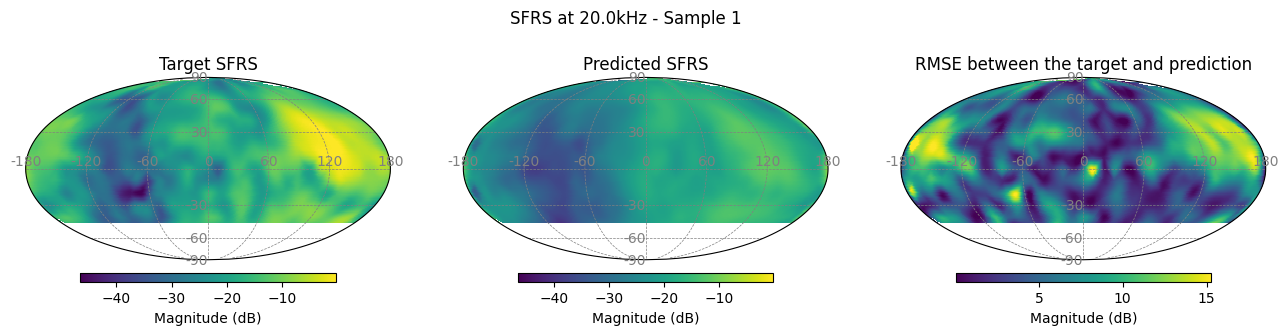

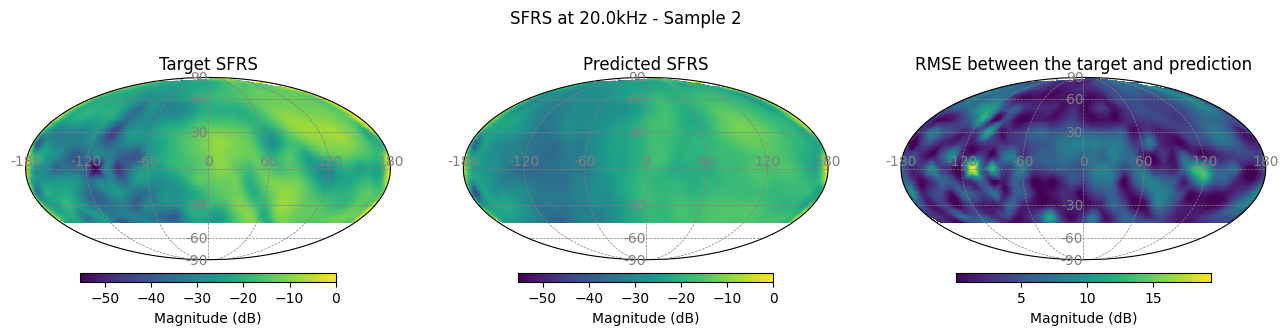

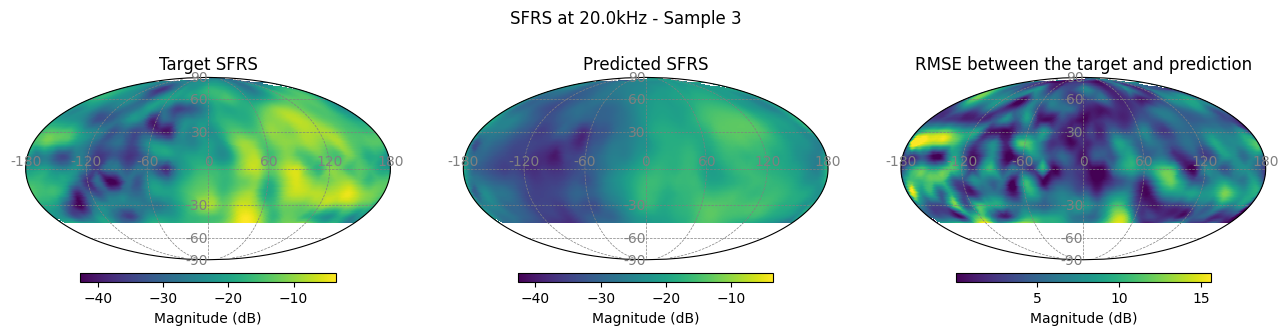

Average RMSE: 5.1247
Average Accuracy: 0.8588


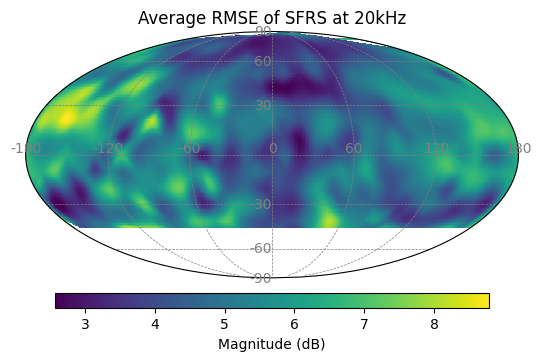

In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import math
from torchvision.models import resnet18, resnet50
from efficientnet_pytorch import EfficientNet
import cartopy.crs as ccrs
from scipy.interpolate import griddata
import scipy.io

# Model parameters
d_model = 2048
nhead = 16
dropout = 0.3
lr = 1e-4
weight_decay = 1e-2
desired_freqs = [20000]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def plot_sfrs_sphere(ax, azimuths, elevations, hrtf_data, title, vmin, vmax):
    target_azimuths = np.linspace(-180, 180, 360)
    target_elevations = np.linspace(-90, 90, 180)
    target_grid_azimuths, target_grid_elevations = np.meshgrid(target_azimuths, target_elevations)

    xi, yi = np.degrees(azimuths), np.degrees(elevations)
    zi = griddata((xi.flatten(), yi.flatten()), hrtf_data.flatten(),
                  (target_grid_azimuths, target_grid_elevations), method='cubic')

    pcm = ax.pcolormesh(target_grid_azimuths, target_grid_elevations, zi,
                        cmap='viridis', vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(), shading='auto')

    cbar = plt.colorbar(pcm, orientation='horizontal', pad=0.05, aspect=30, shrink=0.7, ax=ax)
    cbar.set_label('Magnitude (dB)')

    for az_deg in [-180, -120, -60, 0, 60, 120, 180]:
        ax.text(az_deg, 0, f'{az_deg}',
                verticalalignment='bottom', horizontalalignment='center',
                transform=ccrs.Geodetic(), color='grey')

    for el_deg in [-90, -60, -30, 30, 60, 90]:
        ax.text(0, el_deg, f'{el_deg}',
                verticalalignment='center', horizontalalignment='right',
                transform=ccrs.Geodetic(), color='grey')

    ax.gridlines(color='gray', linestyle='--', linewidth=0.5)
    ax.set_global()
    ax.set_title(title)

def plot_hrtf_comparison(azimuths, elevations, ground_truth, predicted, title):
    all_data = np.concatenate([ground_truth.flatten(), predicted.flatten()])
    vmin, vmax = np.min(all_data), np.max(all_data)

    fig = plt.figure(figsize=(16, 3.5))
    projection = ccrs.Mollweide()

    # Ground Truth
    ax1 = fig.add_subplot(131, projection=projection)
    plot_sfrs_sphere(ax1, azimuths, elevations, ground_truth, "Target SFRS", vmin, vmax)

    # Prediction
    ax2 = fig.add_subplot(132, projection=projection)
    plot_sfrs_sphere(ax2, azimuths, elevations, predicted, "Predicted SFRS", vmin, vmax)

    rmse = np.array(RMSE_loss(predicted, ground_truth))
    emin, emax = np.min(rmse), np.max(rmse)
    ax3 = fig.add_subplot(133, projection=projection)
    plot_sfrs_sphere(ax3, azimuths, elevations, rmse, "RMSE between the target and prediction", emin, emax)

    plt.suptitle(title)
    plt.show()

# Positional Encoding for Transformer Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=33):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Coordinate Embedding Layer
class CoordinateEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(CoordinateEmbedding, self).__init__()
        self.linear = nn.Linear(3, embedding_dim)

    def forward(self, x):
        return self.linear(x)

# Attention Mechanism
class Attention(nn.Module):
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(feature_dim, 1))
        self.scale = 1.0 / (feature_dim ** 0.5)

    def forward(self, x):
        scores = torch.matmul(x, self.attention_weights) * self.scale
        weights = F.softmax(scores, dim=1)
        weighted_sequence = x * weights
        aggregated = torch.sum(weighted_sequence, dim=1)
        return aggregated

# Combined Model that uses Transformer and Image Processing Model
class CombinedModel(nn.Module):
    def __init__(self, input_dim=3, num_encoder_layers=1, model_type='resnet18'):
        super(CombinedModel, self).__init__()
        self.landmark_embedding = CoordinateEmbedding(d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.attention = Attention(d_model)

        # Select model type for image processing
        if model_type == 'resnet18':
            self.resnet = resnet18(pretrained=True)
        elif model_type == 'resnet50':
            self.resnet = resnet50(pretrained=True)
        elif model_type == 'efficientnet':
            self.resnet = EfficientNet.from_pretrained('efficientnet-b0')

        # Adjust the final fully connected layer based on model type
        if model_type in ['resnet18', 'resnet50']:
            self.resnet.fc = nn.Linear(self.resnet.fc.in_features, d_model)
        elif model_type == 'efficientnet':
            self.resnet._fc = nn.Linear(self.resnet._fc.in_features, d_model)

        # Combine landmark and image features
        self.combine_features = nn.Linear(d_model * 2, d_model)
        self.dropout = nn.Dropout(dropout)
        self.linear_out = nn.Linear(d_model, 393)

    def forward(self, landmarks, images):
        # Process landmarks
        landmarks = landmarks.squeeze(1)
        landmarks = landmarks.permute(0, 2, 1)
        x_landmarks = self.landmark_embedding(landmarks)
        x_landmarks = self.pos_encoder(x_landmarks)
        x_landmarks = self.transformer_encoder(x_landmarks)
        x_landmarks = self.attention(x_landmarks)

        # Process images
        x_images = self.resnet(images)

        # Combine features
        combined = torch.cat((x_landmarks, x_images), dim=1)
        x = self.combine_features(combined)
        x = self.dropout(x)
        x = self.linear_out(x)

        return x

# Load model with specified model type
def load_model(model_path, model_type='resnet18'):
    model = CombinedModel(model_type=model_type).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Prepare test data
def prepare_test_data(test_data_path):
    test_dataset = torch.load(test_data_path)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    return test_loader

# RMSE calculation function
def RMSE_loss(predicted, ground_truth):
    predicted = torch.tensor(predicted, dtype=torch.float32)
    ground_truth = torch.tensor(ground_truth, dtype=torch.float32)
    mse = (predicted - ground_truth) ** 2
    rmse = torch.sqrt(mse)
    return rmse

# Plot RMSE maps for SFRS comparison
def plot_overall_average_rmse(rmse_per_freq):
    fig = plt.figure(figsize=(8, 4))
    projection = ccrs.Mollweide()
    emin = np.min(rmse_per_freq)
    emax = np.max(rmse_per_freq)

    # Only one subplot as we are testing a single frequency
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    freq_label = f"{int(desired_freqs[0]/1000)}kHz"
    plot_sfrs_sphere(ax, azim_data, elev_data, rmse_per_freq[0], f"Average RMSE of SFRS at {freq_label}", emin, emax)

    plt.show()

# Test the model
def test_model(model, test_loader, desired_freq):
    rmse_all = []
    accuracy_all = []
    with torch.no_grad():
        for i, (landmarks, images, labels) in enumerate(test_loader):
            landmarks, images, labels = landmarks.to(device), images.to(device), labels.to(device)
            prediction = model(landmarks, images).squeeze(0).cpu().numpy()
            labels_np = labels.squeeze(0).cpu().numpy()

            rmse = RMSE_loss(prediction, labels_np)
            rmse_all.append(rmse)
            accuracy = 1 - np.sqrt(np.mean((prediction - labels_np) ** 2)) / (np.max(labels_np) - np.min(labels_np))
            accuracy_all.append(accuracy)

            if i < 3:
                plot_hrtf_comparison(azim_data, elev_data, labels_np, prediction, f"SFRS at {desired_freq/1000}kHz - Sample {i+1}")

    rmse_mean = np.mean(rmse_all, axis=0)
    accuracy_mean = np.mean(accuracy_all)

    print(f"Average RMSE: {np.mean(rmse_mean):.4f}")
    print(f"Average Accuracy: {accuracy_mean:.4f}")

    return rmse_mean, accuracy_mean

# Main function to test multiple models
def main():
    model_types = ['resnet18']
    rmse_per_freq = []
    for model_type in model_types:
        print(f"\nTesting model type: {model_type} at {desired_freqs[0]/1000}k Hz")
        model_path = f"/content/drive/MyDrive/5305/Model/combined_model_L_{desired_freqs[0]//1000}k_{model_type}.pth"
        test_data_path = f"/content/drive/MyDrive/5305/Data/Processed/test_norm_L{desired_freqs[0]/1000:.1f}k_with_images.pth"

        model = load_model(model_path, model_type=model_type)
        test_loader = prepare_test_data(test_data_path)

        rmse_mean, accuracy_mean = test_model(model, test_loader, desired_freqs[0])
        rmse_per_freq.append(rmse_mean)

    plot_overall_average_rmse(rmse_per_freq)

if __name__ == "__main__":
    main()

